In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as sci
import time
import pip
from getdist import plots, MCSamples
%matplotlib inline

In [3]:
def install(package):
    pip.main(['install', package])
    return

def likelihood(mod, dat, sigma): # retorna escalar, log(L)
    sig = np.diagonal(sigma)
    L = -0.5*chi2(mod, dat, sigma)[0]  + np.sum(-0.5*np.log(2*np.pi*sig**2))
    #pp = np.argwhere((a1==-np.inf))
    #a1[pp] = 0
    return L


def chi2(mod, dat, sigma):
    sig = np.diagonal(sigma)
    AA = np.sum(((dat - mod)/sig)**2)
    BB = np.sum((dat - mod)/sig**2)	
    CC = np.sum(1/sig**2)
    chi = AA - (BB**2)/CC
    return chi, BB/CC


def prior(theta): # vector de parametros anterior y posterior
    ct = 1
    r = np.diag(np.ones(len(theta))*ct)
    p = -0.5*np.log(np.linalg.det(2*np.pi*r)) + -0.5*theta.dot((np.linalg.inv(r)).dot(theta)) 
    return p


def acepta(T1, pos1, T2, pos2, m1, m2):
    alpha = min(pos2 - pos1, 0) # log(alpha)
    u = np.log(np.random.uniform())
    if u<alpha:
        return T2, pos2, m2
    else:
        return T1, pos1, m1


def EHubble(theta, z): # parametro de hubble
    om0 = theta[0]
    ol = theta[1]
    w = theta[2]
    arg = om0*(1 + z)**3 + (1 - om0 - ol)*(1 + z)**2 + ol*(1 + z)**(3*(1 + w))
    EE = np.sqrt(arg)
    return EE, arg


def modelo(theta,z): # modulo de la distancia teorico
    om0 = theta[0]
    ol = theta[1]
    omega_k = 1 - om0 - ol
    E = EHubble(theta, z)[0]
    I = sci.cumtrapz(1/E, z, initial=0)+z[0]*((1/E)[0] + 1)/2
    o_k_s = np.sqrt(abs(omega_k))
    if omega_k==0:
        dl = (1 + z)*I
    elif omega_k<0:
        dl = (1 + z)*np.sin(o_k_s*I)/o_k_s
    elif omega_k>0:	
        dl = (1 + z)*np.sinh(o_k_s*I)/o_k_s	
    dist = 5*np.log10(dl)
    if (-np.inf==dist).any(): 
        print(theta)
    return dist


def tasa(tant, tpos):
    l = len(tant)
    if np.sum(tant==tpos)==l:
        c = 0
    else:
        c = 1
    return c


def revisa(theta, z):
    arg = EHubble(theta, z)[1]
    bol = np.sum(arg<0)
    if bol>0:
        a = 0
    else:
        a = 1
    return a


def region(f, x, y, z, alpha, n):
    m = np.int(np.around(alpha*n,0))
    argsort = np.argsort(f)
    xs = x[argsort]
    ys = y[argsort]
    zs = z[argsort]
    xsa = xs[:m]
    ysa = ys[:m]
    zsa = zs[:m]
    return xsa, ysa, zsa


def grafica(x, y, xmin, ymin, sx, sy, bins=100): #scatter+marginales
    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    # the scatter plot:
    axScatter.scatter(x, y, color='darkred', alpha=.4)
    axScatter.scatter(xmin, ymin, color='black', label='mejor fit '+str(np.around(xmin, 3))+' '+str(np.around(ymin,3)))
    axScatter.legend()

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    a = 0.1
    axScatter.set_xlim((min(x)-a, max(x)+a))
    axScatter.set_ylim((min(y)-a, max(y)+a))
    if sx=='t1':
        sx = '$\Omega_{m,0}$'
    elif sx=='t2':
        sx = '$\Omega_{DE,0}$'
    else:
        sx = 'w'
    if sy=='t1':
        sy = '$\Omega_{m,0}$'
    elif sy=='t2':
        sy = '$\Omega_{DE,0}$'
    else:
        sy = 'w'

    axScatter.set_xlabel(sx)
    axScatter.set_ylabel(sy)

    
    axHistx.hist(x, bins=bins)
    axHisty.hist(y, bins=bins, orientation='horizontal')

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    plt.show()
    return

# fuente https://matplotlib.org/examples/pylab_examples/scatter_hist.html

def argmin1(t1, t2, t3, z, dat, sig): # calcula el min om, ol, w en base a chi2	
    minchic = np.inf
    a = 0
    for i,j,k in zip(t1,t2,t3):
        mo = modelo(np.array([i,j,k]),z)
        chic = chi2(mo, dat, sig)[0]
        if chic<minchic:
            amin = a
            minchic = chic
        a += 1	
    return t1[amin], t2[amin], t3[amin]


def argmin2(t1, t2, t3, V): # busca en base a vector chi2 y devulve minimos de los parametros	
    amin = np.argmin(V)
    return t1[amin], t2[amin], t3[amin]


def dx2(s, n_p):
    """
    s: sigmas
    n_p: numero de parametros
    """
    delta_x_2 = gammainccinv(n_p/2, erfc(s/np.sqrt(2)))
    return delta_x_2


def samples_s(sa1, sa2, x2, d_x2): # determina samples dentro de sigmas
    ind_sam = np.where(x2<=min(x2)+d_x2)
    return sa1[ind_sam], sa2[ind_sam]


def cuenta(x2, W):
    """
    recibe muestras de una distribucion y X2 para determinar los puntos y X2 para las regiones de credibilidad de 0.68, 0.95 y 0.99 
    """
    ms = W.shape[1]
    args = np.argsort(x2)
    W = W[:,args]  
    ms68 = int(np.rint(ms*0.68))
    ms95 = int(np.rint(ms*0.95))
    ms99 = int(np.rint(ms*0.99))
    R = np.array([])
    for wi in W:
        R = np.concatenate((R, np.array((wi[:ms68], wi[:ms95], wi[:ms99]))))
    return R, x2[ms68], x2[ms95], x2[ms99]

In [4]:
# install('getdist')

# saved things directory
direc = '/home/mauricio/Documents/Uni/Intro_2/' + 'gal.txt'

# Carga de datos
redshift = np.genfromtxt('gal.txt', usecols=(1))
mu_obs = np.genfromtxt('gal.txt', usecols=(2)) # m - M
cov = np.genfromtxt('gal.txt', usecols=(3))

p = np.argsort(redshift)
redshift = redshift[p]
mu_obs = mu_obs[p]
cov = cov[p]
cov = np.diag(cov)


In [17]:
# configuracion cadena

# params
labs = [r'$\Omega_{m}$', r'$\Omega_{\Lambda}$', r'w']
labs1 = [r'\Omega_{m}', r'\Omega_{\Lambda}', r'w']

# numero de cadenas
M = 1
# matriz que guarda cadenas, chi2, dist. post., covarianza y tasa.
Chains = []
Xi2 = []
Post = []
COV = []
Tasa = []
# estado de covarianza, ajustable o no
pcov = 1
# numero de parametros
params = 3
# 0.6 para tres parametros, 1.2 para dos 
if params==2:
    r = 1.2e-2 
elif params==3:
    r = 0.6e-2
t = 0.1
# covarianza inicial
cov_ini = np.diag(np.array([0.4, 1.125, 4])**2)*0.5e-2
covarianza = cov_ini
if pcov==1:
    print('covarianza ajustable')
else:
    print('covarianza estatica', r)
print('parametros', params)

while True:	
    T = np.random.uniform(low=[0,0,-5], high=[1, 2, 0], size=3)
    if revisa(T,redshift)==1: 
        break
#T = np.loadtxt('initial')
#np.savetxt('initial', T)

covarianza ajustable
parametros 3


In [22]:
d = 0
# numero de muestras
N = 10000
# matrices utilizadas en cadena, dist. post., modelo, chi2 y ratio de la cadena actual
chain = [] 
post = [] 
mod = []
chi_2 = []
Ratio = []
acept = 0
# params iniciales, revisa que sean validos	
#covarianza = np.diag(np.array([0.4, 1.125, 4])**2)*0.5e-2
"""
if o!=0:
    while True:
        T = np.random.multivariate_normal(mean=np.mean(Chains[o - 1][bur:,:], axis=0), cov=covarianza)
        if revisa(T,redshift)==1: 
            break
"""
print('covarianza', covarianza)
print('params iniciales', T)
mu_mod = modelo(T, redshift)
pos = likelihood(mu_mod,mu_obs,cov)# + prior(T) 
# guarda datos iniciales de la cadena 
chain.append(T)
post.append(pos)
mod.append(mu_mod)
chi_2.append(chi2(mu_mod, mu_obs, cov)[0])
Ratio.append(100)	

# pasos de cadena
Ti = time.time()
for i in range(N):
    # revisa si se paso umbral de burn in
    """	
    if chi_2[i]<=580 and d==0 and o!=0:
        covarianza = COV[o]
        d = 1
        print('actualizada')
        print(covarianza)
    """	
    # selecciona ultimo elemento de la cadena
    T1 = chain[i]
    # itera hasta que encuentra un proposal valido
    while True:
        T2 = np.random.multivariate_normal(mean=T1, cov=covarianza)
        #T2[1] = 1 - T2[0]
        if params==2:
            T2[2] = -1
        # que la raiz no sea imaginaria		
        if revisa(T2,redshift)==1: 
            break
    # selecciona ultimo modelo
    mod1 = mod[i]
    # calcula modelo con proposal
    mod2 = modelo(T2, redshift)
    # selecciona ultima dis. post.
    pos1 = post[i]
    # calcula nueva dist. post.
    pos2 = likelihood(mod2,mu_obs,cov) + prior(T2)
    # decision de aceptacion
    A = acepta(T1, pos1, T2, pos2, mod1, mod2)
    # guarda la variable aceptada (puede ser la anterior o proposal)
    chain.append(A[0])
    post.append(A[1])
    mod.append(A[2])
    chi_2.append(chi2(A[2], mu_obs, cov)[0])
    # ratio de aceptacion
    acept += tasa(chain[i], chain[i + 1]) 
    Ratio.append(acept/(i+1)*100)

Tf = time.time()
print('Tiempo cadena', np.around(Tf - Ti, 0), 's')
ratio = acept/N*100
print('ratio %', np.rint(ratio))

# convierte listas a array
post = np.array(post)
chain = np.array(chain)
mod = np.array(mod)
chi_2 = np.array(chi_2)
Ratio = np.array(Ratio)

# guarda cadenas de cada parametro
t1 = chain[:,0]#Get the getdist MCSamples objects for the samples, specifying same parameter
t2 = chain[:,1]
t3 = chain[:,2]
""
# determina burn in
bur = np.nonzero(chi_2<=580)[0][0]
print('burn in', bur)

# busca argumento del minimo de chi2
t1m, t2m, t3m = np.around(argmin2(t1, t2, t3, chi_2), 3)
print('Xi2 minimo oml, w', t1m, t2m, t3m)
"""
# guarda cadena, chi2, acceptance ratio y covarianza en txt
np.savetxt(direc+'chain_'+str(o), np.vstack((chain[:,0], chain[:,1], chain[:,2], chi_2, Ratio)).T)
np.savetxt(direc+'chain_'+str(o)+'_cov', covarianza)
"""


covarianza [[0.0008     0.         0.        ]
 [0.         0.00632813 0.        ]
 [0.         0.         0.08      ]]
params iniciales [ 0.8146758   0.10474601 -1.78619235]


/home/mauricio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


Tiempo cadena 16.0 s
ratio % 17.0
burn in 61
Xi2 minimo oml, w 0.28 0.606 -1.158


"\n# guarda cadena, chi2, acceptance ratio y covarianza en txt\nnp.savetxt(direc+'chain_'+str(o), np.vstack((chain[:,0], chain[:,1], chain[:,2], chi_2, Ratio)).T)\nnp.savetxt(direc+'chain_'+str(o)+'_cov', covarianza)\n"

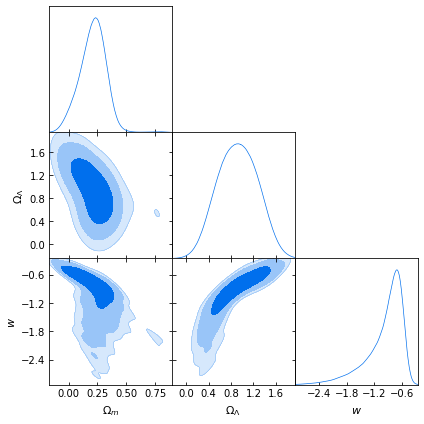

In [23]:
#Get the getdist MCSamples objects for the samples, specifying same parameter
#names and labels; if not specified weights are assumed to all be unity
ndim = 3
names = ["x%s"%i for i in range(ndim)]
labels = ["x_%s"%i for i in range(ndim)]
samps = np.vstack((t1, t2, t3)).T
samples = MCSamples(samples=samps, names=labs1, labels=labs1)

#Triangle plot
g = plots.getSubplotPlotter()
samples.updateSettings({'contours': [0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 3
g.triangle_plot([samples], filled=True)